# dataset

In [81]:
import os
import cv2
import matplotlib.pyplot as plt

mask_path='/media/sdb/CVDataset/ObjectSegmentation/DAVIS/Annotations/480p/bear/00000.png'
#mask_path='/media/sdb/CVDataset/ObjectSegmentation/DAVIS/Annotations/480p/bmx-bumps/00074.png'
mask=cv2.imread(mask_path,0)
print(np.unique(mask))
points=cv2.findNonZero(mask)
rect=cv2.boundingRect(points)
x1,y1,w,h=rect
crop_mask=mask[y1:y1+h,x1:x1+w]
resize_mask=cv2.resize(crop_mask,(320//2,240//2),interpolation=cv2.INTER_NEAREST)
print(np.unique(resize_mask))

[ 0 38]
[ 0 38]


In [82]:
print(rect)

min_x=None
max_x=None
min_y=None
max_y=None
for s1 in points:
    for (x,y) in s1:
        if min_x is None:
            min_x=x
            max_x=x
            min_y=y
            max_y=y
        else:
            min_x=min(x,min_x)
            max_x=max(x,max_x)
            min_y=min(y,min_y)
            max_y=max(y,max_y)

print(min_x,max_x,min_y,max_y) 
print(min_x,min_y,max_x-min_x,max_y-min_y)

print(mask.shape)
print(crop_mask.shape)
print(resize_mask.shape)

(96, 214, 369, 221)
96 464 214 434
96 214 368 220
(480, 854)
(221, 369)
(120, 160)


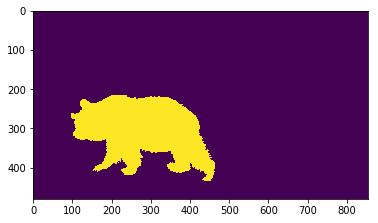

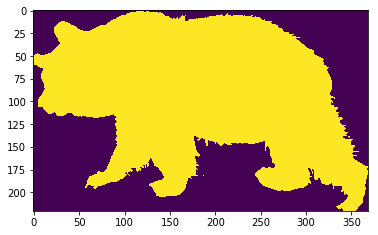

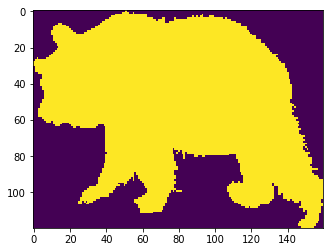

In [84]:
plt.imshow(mask)
plt.show()

plt.imshow(crop_mask)
plt.show()

plt.imshow(resize_mask)
plt.show()

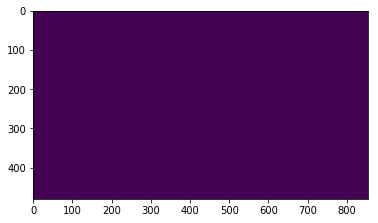

(0, 0, 0, 0)


In [28]:
mask_path='/media/sdb/CVDataset/ObjectSegmentation/DAVIS/Annotations/480p/bmx-bumps/00074.png'
mask=cv2.imread(mask_path,0)
plt.imshow(mask)
plt.show()

points=cv2.findNonZero(mask)
rect=cv2.boundingRect(points)
x1,y1,w,h=rect
print(rect)

In [73]:
from train import get_parser
from dataset.dataset import dataset
import torch.utils.data as TD
from utils.train_tools import get_ckpt_path,get_model
import torch
import os

os.chdir(os.path.expanduser('~/git/torch_homograph'))
#argv='--use_mask=True --note=mask'
argv='--use_mask=False --note=basic'
parser=get_parser()
args=parser.parse_args(argv.split(' '))
log_dir=os.path.join(args.log_dir,args.model_name,args.patch_dataset,args.note)
ckpt_path = get_ckpt_path(log_dir)
print('load checkpoint file from', ckpt_path)
state_dict = torch.load(ckpt_path)

model=get_model(args)    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

if 'model_state' in state_dict.keys():
    model.load_state_dict(state_dict['model_state'])
else:
    model.load_state_dict(state_dict)

val_loader=TD.DataLoader(dataset=dataset(args,split='test'),
                           batch_size=args.batch_size,
                           shuffle=True,
                           drop_last=True,
                           num_workers=2)

model.eval()
for idx,(datas) in enumerate(val_loader):
    imgs=datas['imgs'].to(device).float()
    points_offset=datas['points_offset'].to(device).float()
    points_perturb=datas['points_perturb'].data.cpu().numpy()
    img_patch_path=datas['img_path']
    outputs=model.forward(imgs)
    break

no checkpoint file given, auto find /home/yzbx/tmp/logs/vggstyle_homo/cocostuff/basic/2018-11-28___17-02-34/model-last-100.pkl
load checkpoint file from /home/yzbx/tmp/logs/vggstyle_homo/cocostuff/basic/2018-11-28___17-02-34/model-last-100.pkl
cocostuff test dataset image size is 1000


torch.Size([32, 8])
no perturb [[ 70. 149.]
 [198. 149.]
 [198. 277.]
 [ 70. 277.]]
predict perturb [[ 69.35367298 151.61929393]
 [195.85021782 139.10710526]
 [198.8076694  286.90259647]
 [ 67.83377862 270.99927044]]
true perturb [[ 74 167]
 [177 138]
 [188 285]
 [ 64 284]]
groundtrue [  4.  18. -21. -11. -10.   8.  -6.   7.]
predict [-0.646327   2.619294  -2.1497822 -9.892895   0.8076694  9.902596
 -2.1662214 -6.0007296]


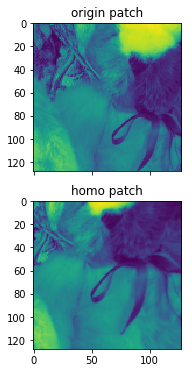

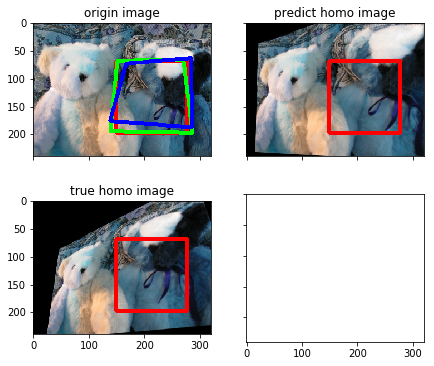

In [78]:
print(outputs.shape)
batch_offset=outputs.data.cpu().numpy()
true_offset=points_offset.cpu().numpy()
points_perturb_true=datas['points_perturb'].data.cpu().numpy()
img_patch_path=datas['img_path']
batch_points=points_perturb_true-true_offset
batch_points_perturb=batch_points+batch_offset

import cv2
import matplotlib.pyplot as plt
def show_images(images,titles=None,vmin=None,vmax=None):
    fig, axes = plt.subplots(2, (len(images)+1)//2, figsize=(7, 6), sharex=True, sharey=True)
    ax = axes.ravel()

    for i in range(len(images)):
        ax[i].imshow(images[i],vmin=vmin,vmax=vmax)
        if titles is None:
            ax[i].set_title("image %d"%i)
        else:
            ax[i].set_title(titles[i])

    plt.show()
    
def np_to_points(yx_pts):
    xy_pts=yx_pts.copy()
    xy_pts[:,0]=yx_pts[:,1]
    xy_pts[:,1]=yx_pts[:,0]
    points=[xy_pts.reshape((-1,1,2)).astype(np.int32)]
    return points

batch_imgs=imgs.data.cpu().numpy()
batch_imgs=128*(batch_imgs+1)
batch_imgs=batch_imgs.astype(np.uint8)
for idx in range(args.batch_size):
    pts_img_patch=batch_points[idx,:].reshape(4,2)
    pts_img_patch_perturb=batch_points_perturb[idx,:].reshape(4,2)
    pts_img_patch_perturb_true=points_perturb_true[idx,:].reshape(4,2)
    
    print('no perturb',pts_img_patch)
    print('predict perturb',pts_img_patch_perturb)
    print('true perturb',pts_img_patch_perturb_true)
    
    print('groundtrue',true_offset[idx,:])
    print('predict',batch_offset[idx,:])
    
    h_predict, status = cv2.findHomography(pts_img_patch, pts_img_patch_perturb, cv2.RANSAC)
    h_true, status = cv2.findHomography(pts_img_patch, pts_img_patch_perturb_true, cv2.RANSAC)
    img1_patch=batch_imgs[idx,0,:,:]
    img2_patch=batch_imgs[idx,1,:,:]
    show_images([img1_patch,img2_patch],
                ['origin patch','homo patch'])
    
    img1=cv2.resize(cv2.imread(img_patch_path[idx]),(320,240))
    img_homo_predict=cv2.warpPerspective(img1,h_predict,dsize=(320,240))
    img_homo_true=cv2.warpPerspective(img1,h_true,dsize=(320,240))
    img1=cv2.polylines(img1,np_to_points(pts_img_patch),isClosed=True,color=(255,0,0),thickness=5)
    img1=cv2.polylines(img1,np_to_points(pts_img_patch_perturb),isClosed=True,color=(0,255,0),thickness=5)
    img1=cv2.polylines(img1,np_to_points(pts_img_patch_perturb_true),isClosed=True,color=(0,0,255),thickness=5)
    
    img_homo_predict=cv2.polylines(img_homo_predict,np_to_points(pts_img_patch),
                                   isClosed=True,color=(255,0,0),thickness=5)
    img_homo_true=cv2.polylines(img_homo_true,np_to_points(pts_img_patch),
                                   isClosed=True,color=(255,0,0),thickness=5)
    show_images([img1,img_homo_predict,img_homo_true],
                ['origin image','predict homo image','true homo image'])
    
    break